# Instructors' Guide:

This guide accompanies the IBM Quantum classroom module on the Variational Quantum Eigensolver (VQE). Here we outline intended use, learning goals, and instructional materials available.


## Using IBM Quantum Classroom Modules

These classroom modules are designed to be self-contained, interactive lessons on various topics commonly covered in a university classroom. The module provides context and instruction on the topic, then asks the students to follow along by answering check-in questions and filling in Qiskit code when prompted. Finally, at the end of the lesson, the students are asked to complete homework-style questions and problems.

The modules should take about an hour to complete and can be conducted either in or out of class. We suggest using them as a group activity to encourage discussion among students, but they could work just as well as individual homework.

## Prerequisites

We recommend that students have a basic understanding of undergraduate-level general chemistry, quantum information, and computational optimization methods. This module might be suitable for professors running a curriculum that includes the following textbook chapters and who are interested in introducing quantum algorithms:
- (as a prerequisite)  Brown, "Chemistry: The Central Science, 14th edition", from chapters 1 to 6.
- (as a prerequisite) Atkins, "Chemical principles: the quest for insight", from chapters 2 to 3.
- (as a prerequisite) Tjo, "Introductory Chemistry, 6th edition", chapters 4, 5, 7, and 9.
- Jensen, "Introduction to Computational Chemistry", chapters 1 to 5.
- Szabo, "Modern Quantum Chemistry", chapters 1 to 3, best for chapters 1 to 4.

## Learning goals

By the end of this lesson students should be able to: 
- describe the overall process of VQE and the role and importance of the ansatz and optimizers
- write code to construct VQE algorithms and get the ground state energy of the $H$ atom and $H_2$ molecule
- define and compute reaction energy of the $H+H = H_2$ process
- assess VQE accuracy and discuss current challenges in VQE


## Materials

1. The python notebook:
    * a. Text explanation
    * b. Video
    * c. Check-in questions with solutions available to students. These are equally useful for self-assessment in individual work, or discussion question in the group work context.
    * d. Homework-style questions at the module's end with solutions not visible to students.
2. Instructor solution key for the python notebook, including solutions to homework-style questions.
3. Accompanying YouTube video to be used as a primer or a light overview if the full notebook is not being used.
4. The calculations in this notebook were benchmarked on IBM's latest QPUs and took less than 8 minutes of QPU time. This is only an estimate; individual runs may vary in duration and queueing. Simulator instructions are included should monthly open use be exceeded.
   
---

## [ STUDENT-FACING MODULE STARTS HERE] ##

# Variational Quantum Eigensolver (VQE)

For this module, students must have a working Python environment with the following packages installed with their latest version:
- `qiskit`
- `qiskit_ibm_runtime`
- `qiskit-aer`
- `qiskit.visualization`

To set up and install these packages, see the [Install Qiskit](/docs/guides/install-qiskit) guide. To run jobs on real quantum computers, students will need an account with IBM Quantum by following the steps in the [Set up your IBM Cloud account](/docs/guides/cloud-setup) guide.

*This module has been tested and used for approximately 8 minutes of QPU time. This is an estimate, and your actual usage may vary.*


## 1. Introduction

Since the development of the quantum mechanical model in the early 20th century, scientists have understood that electrons do not follow fixed paths around an atom's nucleus but rather exist in regions of probability called orbitals. These orbitals correspond to specific, discrete energy levels that electrons can occupy. Electrons naturally reside in the lowest available energy levels, known as the ground state. However, if an electron absorbs sufficient energy, it can jump to a higher energy level, entering an excited state. This excited state is temporary, and the electron will eventually return to a lower energy level, releasing the absorbed energy, often in the form of light. This fundamental process of energy absorption and emission is crucial to understanding how atoms interact and form bonds.

When atoms come together to form molecules, their atomic orbitals combine to form molecular orbitals. The arrangement and energy levels of electrons within these molecular orbitals dictate the properties of the resulting molecule and the strength of the chemical bonds. For instance, in the formation of a hydrogen molecule ($H_2$) from two individual hydrogen atoms, the electron from each atom occupies atomic orbitals. As the atoms approach each other, these atomic orbitals overlap and combine to form new molecular orbitals—one with lower energy (a bonding orbital) and one with higher energy (an anti-bonding orbital). The two electrons, one from each hydrogen atom, will preferentially occupy the lower-energy bonding orbital, leading to the formation of a stable covalent bond that holds the $H_2$ molecule together. The energy difference between the separated atoms and the formed molecule, particularly the energy of the electrons in the molecular orbitals, determines the stability and properties of the bond.

In the following sections, we will delve into this process of molecular formation, focusing specifically on the $H_2$ molecule. We will use a real quantum computer, combined with classical optimization techniques, to investigate the energy of this simple yet fundamental process. This experiment will provide a practical demonstration of how quantum computation can be applied to solve problems in computational chemistry, offering insights into the crucial role of electron energy.



## 2. VQE - A Variational Quantum Algorithm for Eigenvalue problem

### Approximation techniques for chemistry - Variational Principle and the basis set

Erwin Schrödinger's contributions to quantum mechanics go beyond introducing a new electronic model; fundamentally, he established wave mechanics by developing the famous time-dependent Schrödinger equation:

$$
i\hbar \frac{d}{dt}|\psi\rangle = \hat{H}|\psi\rangle
$$

Here, $\hat{H}$ is the Hamiltonian operator, which represents the total energy of the system, and $|\psi\rangle$ is the wave function that contains all the information about the system’s quantum state. (Note: $\frac{d}{dt}$ is the total time derivative, and we do not explicitly include the energy eigenvalue $E$ here.)

However, in many practical applications—such as determining the allowed energy levels of atoms and molecules—we instead use the time-independent Schrödinger equation (energy eigenvalue equation), which is derived from the time-dependent form by assuming a stationary state. A stationary state is a quantum state in which the probability density of finding a particle at a given point in space does not change over time. 

$$ \hat{H}|\psi\rangle = E|\psi\rangle $$

In this form, $E$ represents the energy eigenvalue corresponding to the quantum state $|\psi\rangle$. The Hamiltonian includes various energy contributions, such as the kinetic energy of electrons and nuclei, the attractive forces between electrons and nuclei, and the repulsive forces between electrons.

Solving the energy eigenvalue equation allows us to calculate the quantized energy levels of atomic and molecular systems. However, for molecules, solving it exactly is extremely difficult because the wave function $\Psi$, which describes the spatial distribution of electrons, is highly complex and high-dimensional.

As a result, scientists use approximation techniques to obtain practical and accurate solutions. In this work, we will focus on two key methods:


1. Variational Principle

This method approximates the wave function and adjusts it to get as close as possible to the target energy, usually the ground state energy of the system. The key idea behind the variational principle is simple:

- If we guess a wave function $\Psi_\text{trial}$ (a "trial function"), the energy calculated from it will always be equal to or higher than the ground state energy ($E_0$) of the system.
$$E_\text{approx} = \frac{\langle \Psi_\text{trial}|\hat{H}|\Psi_\text{trial}\rangle}{\langle \Psi_\text{trial}|\Psi_\text{trial}\rangle} \geq E_0$$
- By adjusting parameters $\theta$ in the trial function, $|\Psi_\text{trial}(\theta)\rangle$, we can get a better and better approximation of the ground state energy.
- Its accuracy heavily depends on the choice of the trial wave function $\Psi_\text{trial}$. A poorly-chosen trial function may lead to an energy estimate that is far from accurate.

2. Basis Set Approximation

The second approximation method comes in the stage of constructing the wave function—the basis set approach. In quantum chemistry, solving the Schrödinger equation exactly for molecules is impossible. Instead, we approximate the complex, multi-electron wave function by building it up from simpler, predefined mathematical functions. A **basis set** is essentially a collection of these known mathematical functions, typically centered on the atoms in the molecule, that are used as building blocks to represent the shape and behavior of the electrons in the system. Think of it like trying to recreate a detailed sculpture using only a collection of standard LEGO bricks – the more types and sizes of bricks you have (the larger the basis set), the more accurately you can approximate the original shape.

These basis functions are often inspired by the analytical solutions for simple systems like the hydrogen atom, taking forms like Gaussian or Slater-type functions, though they are still approximations. Instead of working with the theoretically "exact" but intractable full molecular orbitals, we express them as a linear combination (a sum with coefficients) of these basis functions. This method is known as the Linear Combination of Atomic Orbitals (LCAO) approach when the basis functions resemble atomic orbitals. By optimizing the coefficients in this linear combination, we can find the best possible approximate wave function and energy within the limitations of the chosen basis set.
- The more functions included in the basis set, the better the approximation, but this comes at the cost of higher computational effort.
- A small basis set provides a rough estimate, while a large basis set gives more precise results at the expense of requiring significantly more computational resources.

To summarize, to make calculations feasible and reduce computational cost, we use the variational principle by approximating the wave function, which reduces the computational complexity and allows for iterative optimization to minimize energy. Meanwhile, the basis set approach simplifies calculations by representing atomic orbitals as a combination of predefined functions, rather than solving for a continuous wave function directly.


#### Check your understanding
Consider the trial wave function $\Psi_\text{trial}(\alpha,x) = Ae^{- \alpha x^2}$ where $A$ is a normalization constant and $\alpha$ is an adjustable parameter. 

<details>
<summary>

a. Normalize the trial wave function by determining $A$ such that

$$ \int_{-\infty}^{\infty} |\Psi_\text{trial}|^2 dx = 1 $$

b. Compute the expectation value of the Hamiltonian $\hat{H}$ given by:

$$ \hat{H} = -\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + V(x)$$
where $V(x)  = \frac{1}{2}m\omega^2x^2$, which corresponds to a simple harmonic oscillator potential.

c. Use the variational principle to find the optimal $\alpha$ by minimizing $E_\text{approx}(\alpha)$

</summary>

__Answer:__


(a) To normalize given trial wave function:

$$ \int_{-\infty}^{\infty} |\Psi_\text{trial}|^2 dx = \int_{-\infty}^{\infty} A^2 e^{-2 \alpha x^2} dx = 1 $$

Use the Gaussian integral:

$$ \int_{-\infty}^{\infty} e^{-a x^2} dx = \sqrt{\frac{\pi}{a}} \text{,   for } a>0$$ 

set $a = 2\alpha$ then get: 
$$A^2\sqrt{\frac{\pi}{a}} = 1$$
$$\therefore A = (\frac{2\alpha}{\pi})^{1/4}$$

(b) The Hamiltonian for a harmonic oscillator is:

$$ \hat{H} = -\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + \frac{1}{2} m \omega^2 x^2 $$

- Kinetic Energy Expectation Value
$$ \langle T \rangle = -\frac{\hbar^2}{2m} \int_{-\infty}^{\infty} \Psi_\text{trial}^* \frac{d^2}{dx^2} \Psi_\text{trial} dx $$

Taking the second derivative:

$$
\frac{d}{dx} \Psi_\text{trial} = -2\alpha x A e^{-\alpha x^2}
$$

$$
\frac{d^2}{dx^2} \Psi_\text{trial} = A e^{-\alpha x^2} (4\alpha^2 x^2 - 2\alpha)
$$

Thus:

$$
T = -\frac{\hbar^2}{2m} \int_{-\infty}^{\infty} A^2 e^{-2\alpha x^2} (4\alpha^2 x^2 - 2\alpha) dx
$$

Using standard Gaussian integral results:

$$
\langle T \rangle = \frac{\hbar^2 \alpha}{2m}
$$

- Potential Energy Expectation Value
$$
\langle V \rangle = \frac{1}{2} m \omega^2 \int_{-\infty}^{\infty} x^2 |\Psi_\text{trial}|^2 dx
$$

Using:

$$
\int_{-\infty}^{\infty} x^2 e^{-a x^2} dx = \frac{\sqrt{\pi}}{2a^{3/2}}
$$

we get:

$$
\langle V \rangle = \frac{m \omega^2}{4\alpha}
$$

- Total Energy Expectation Value
$$
\therefore E_\text{approx}(\alpha) = \frac{\hbar^2 \alpha}{2m} + \frac{m \omega^2}{4\alpha}
$$



(c) Optimize $ \alpha $ for Minimum Energy
Differentiate:

$$
\frac{d}{d\alpha} \left( \frac{\hbar^2 \alpha}{2m} + \frac{m \omega^2}{4\alpha} \right) = 0
$$

Solving:

$$
\frac{\hbar^2}{2m} - \frac{m \omega^2}{4\alpha^2} = 0
$$

$$
\alpha_\text{opt} = \frac{m\omega}{2\hbar}
$$

Substituting $ \alpha_\text{opt} $ into $ E_\text{approx} $:

$$
\therefore E_\text{approx} = \frac{\hbar \omega}{2}
$$

which matches the exact quantum harmonic oscillator ground-state energy.

</details>


### VQE (Variational Quantum Eigensolver)

The variational quantum eigensolver (VQE) is the main method that we will use to explore the $H+H = H_2$ process, and here, we will take a look at what VQE is and how it works. But let's first pause and look at one very important thing through the check-in question.

#### Check your understanding
<details>
<summary>

If we already have that many strategies for chemistry problems, then why do we need a quantum computer? And what's the purpose of using both quantum and classical computers together?

</summary>

__Answer:__


Quantum computing has a chance to revolutionize chemistry by tackling problems classical computers struggle with due to the exponential scaling of quantum states. Richard Feynman famously noted that to simulate nature, computations must also be quantum [ref 1].

For example, simulating caffeine with a simplest basis set(STO-3G) would require $10^{48}$ bits, much larger than the total number of stars in the observable universe ($10^{24}$) [ref 2]. A quantum computer can describe the electronic orbitals of caffeine with 160 qubits.

Quantum computers naturally process quantum interactions using superposition and entanglement, which provide a promising way of enabling accurate molecular simulations. Further, we can combine the advantages of both quantum computers (electron simulation) and classical computers (data pre/post processing, algorithm process management, optimization, etc). These are expected to enhance materials discovery, drug design, and reaction predictions, reducing costly trial-and-error experiments. [ref 3][ref 4]

If you want to know why quantum computers are needed for chemistry problems and why use both quantum and classical computing resources, check out the following resources:

- [Emerging quantum computing algorithms for quantum chemistry](https://arxiv.org/abs/2109.02873)
- [Chemistry Beyond Exact Solutions on a Quantum-Centric Supercomputer](https://arxiv.org/html/2405.05068v1)
- [Quantum-centric supercomputing for materials science: A perspective on challenges and future directions](https://www.sciencedirect.com/science/article/pii/S0167739X24002012)

</details>




Now let's go back to VQE. 

VQE combines the power of quantum computers with classical computers, fundamentally using variational principles to get the ground state energy of the system. To understand VQE, first break it down into three parts:



#### (Quantum) Observable: The Molecular Hamiltonian (Energy of a Molecule)

In VQE, the molecular/atomic Hamiltonian is an observable, meaning we can measure its value through experiment. Our goal is to find the lowest possible energy (the ground state energy) of the molecule. To do this, we use a trial quantum state, generated by a parameterized quantum circuit (ansatz). We measure the observable and optimize the quantum state until we reach the lowest possible energy. 

The basis set used for the molecular Hamiltonian determines the number of qubits required and directly affects the accuracy of VQE. Choosing the right basis set is crucial for balancing efficiency and precision. To simplify calculations without changing the basis set, we can use strategies like imposing __symmetry__ and __active space reduction__. Many molecules have symmetrical shapes (like a butterfly or snowflake), meaning some parts behave the same way. Instead of calculating everything separately, we can focus only on unique parts, saving quantum resources, thus leveraging symmetry. In active space reduction, we consider only the important orbitals, as not all electrons significantly impact molecular energy. Electrons close to the nucleus remain mostly unchanged, while others influence bonding. By applying these methods, we can make VQE more efficient while maintaining accuracy.

Once we obtain a molecular Hamiltonian using the proper basis set and strategies above, we need to transform this Hamiltonian into one suitable for quantum computers. Mapping problems to Pauli operators can be quite complicated. This is especially true in quantum chemistry, which works with indistinguishable particles (electrons), since qubits are distinguishable. We will not go into the details of the mappings here, but we refer you to the following resources. A general discussion of mapping a problem to quantum operators can be found in [Quantum Computing in Practice](https://quantum.cloud.ibm.com/learning/en/courses/quantum-computing-in-practice). A more detailed discussion on mapping chemistry problems into quantum operators can be found in [Quantum Chemistry with VQE](https://quantum.cloud.ibm.com/learning/en/courses/quantum-chem-with-vqe).

For this module, we will provide you with the appropriate (one-qubit) Hamiltonians for $H$ and $H_2$ so we can focus on using the quantum computer. These one-qubit Hamiltonians are prepared by using the so-called [STO-6g](https://en.wikipedia.org/wiki/STO-nG_basis_sets) basis set and used [Jordan-Wigner mapping](https://en.wikipedia.org/wiki/Jordan%E2%80%93Wigner_transformation), which is the most straightforward mapping with the simplest physical interpretation, because it maps the occupation of one spin-orbital to the occupation of one qubit. Also, we used [qubit reduction technique by using a symmetry of the Hamiltonian](https://arxiv.org/abs/1701.08213), which uses the patterns in how spin occupations behave to reduce the number of qubits. For the $H_2$ molecule, we assume the distance between the two hydrogen atoms is `0.735` $\mathring A$.

#### (Quantum) Ansatz: The Trial Wave Function (How to build a trivial quantum state with a Quantum Circuit)

For VQE, the ansatz consists of two key components. The first is __initial state preparation__, which sets up the qubit's state by applying quantum gates with no variational parameter. The second component is the __parameterized quantum circuit__, a special quantum circuit with adjustable parameters, similar to dials on a radio. These parameters will be used for the last part — the classical optimizer — to help us reach the best possible ground state.

In the variational principle section, we learned that the quality of the trial state affects the quality of the results of the variational algorithm. This means that choosing a good ansatz is important in VQE. Once again, this is a rich and complex topic. We will not cover the different types of ansatz or their origins here. If you're interested in learning more about parameterized quantum circuits and ansatz, you can explore the following resources: [Ansatz and variational form](https://quantum.cloud.ibm.com/learning/en/courses/variational-algorithm-design/ansaetze-and-variational-forms) of [Variational algorithm design course](hhttps://quantum.cloud.ibm.com/learning/en/courses/variational-algorithm-design), which provides detailed explanations and examples of ansatz.

Since we are going to use a one-qubit Hamiltonian in this module, we need a one-qubit parameterized quantum circuit as an ansatz. We will see 3 types of one-qubit ansatz in the following section. We will compare them and discuss key considerations in selecting an ansatz.

#### (Classical) Optimizer: Fine-Tuning the Quantum Circuit

Once the quantum computer measures the energy of the observable from the ansatz, the parameters of the ansatz and the energy value are sent to the classical optimizer for tuning. This optimization process is performed on a classical computer, typically using general-purpose scientific packages like SciPy.

The classical optimizer treats the measured energy as a cost function. In optimization problems, a cost function (also sometimes called an objective function) is a mathematical function that measures how "good" a particular solution is. The goal of the optimizer is to find the set of parameters that minimizes this cost function. In the context of finding the ground state energy of a molecule, the energy itself serves as the cost function – we want to find the parameters for our quantum circuit (our "solution") that yield the lowest possible energy. The classical optimizer uses this measured energy value (the cost) and determines the next set of optimized parameters for the quantum ansatz. These updated parameters are then sent back to the quantum circuit, and the process is repeated iteratively. With each iteration, the classical optimizer adjusts the parameters to try and reduce the energy (minimize the cost function) until a predefined convergence criterion is met, ideally ensuring that the lowest possible energy (corresponding to the ground state of the molecule for that bond distance and basis set) is found.

There are many optimization strategies provided by scientific packages like SciPy. You can find more in the [Optimization Loops](https://quantum.cloud.ibm.com/learning/en/courses/variational-algorithm-design/optimization-loops) lesson of the [Variational Algorithm Design](https://quantum.cloud.ibm.com/learning/en/courses/variational-algorithm-design) course. Here we will use COBYLA (Constrained Optimization BY Linear Approximations), an optimization algorithm suitable for complicated energy landscapes. In particular, COBYLA does not attempt to calculate a gradient of the function being studied; this is called a gradient-free optimizer. Imagine you are trying to find the highest peak in a mountain range with your eyes closed. Since you can’t see the whole landscape, you take small steps in different directions, while checking if you’re going up or down. COBYLA works in a similar way — it moves through the parameter space, testing different values, gradually improving the result until it finds the best one.

Now you are ready to carry out a VQE calculation. To that end, try the check-in question below which recaps the overall process. 

#### Check your understanding
Fill in the blanks with the correct terms to complete the summary of the Variational Quantum Eigensolver (VQE) process.
<details>
<summary>

VQE is a Variational Quantum Algorithm, which combines the power of (1) ________ and classical computing, used to find the (2) __________ of a molecule. The process begins by defining the (3) __________, which represents the total energy of the system and acts as the observable in quantum measurements. Next, we prepare an (4) __________, a quantum circuit with adjustable parameters that represents the trial wave function of the molecule. These parameters are optimized using a (5) __________, a classical algorithm that adjusts parameters iteratively to minimize the measured energy. In the discussion above we used the (6) __________ optimizer, which refines the ansatz parameters without needing derivative calculations. The process continues until we reach (7) __________, meaning we have found the lowest possible energy of the molecule.

Word Bank:

- classical optimizer
- ground state energy
- hardware efficient
- ansatz
- molecular Hamiltonian
- COBYLA
- quantum computing
- convergence
  
</summary>

__Answer:__


1 → quantum computing

2 → ground state energy

3 → molecular Hamiltonian

4 → ansatz

5 → classical optimizer

6 → COBYLA

7 → convergence

</details>


## 3. Compute the ground state energy of hydrogen atom with VQE

Now, let's use what we've learned to compute the ground state energy of a hydrogen atom. Throughout the module, we will use a framework for quantum computing known as "Qiskit patterns", which breaks workflows into the following steps:

- Step 1: Map classical inputs to a quantum problem
- Step 2: Optimize problem for quantum execution
- Step 3: Execute using Qiskit Runtime Primitives
- Step 4: Post-processing and classical analysis



We will generally follow these steps, though we may not always explicitly label them.

Let's start by loading some necessary packages including Runtime primitives. We will also select the least busy quantum computer available to us.

In [1]:
from numpy import pi

#Load the Qiskit Runtime service
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Batch, SamplerV2 as Sampler, EstimatorV2 as Estimator

import warnings
warnings.filterwarnings("ignore")

# Syntax for first saving your token
# QiskitRuntimeService.save_account(
#     channel="ibm_quantum_platform",
#     token="your_token",
#     instance="your_crn",
#     overwrite=True
# )

#Syntax to load specific account
#service = QiskitRuntimeService(
#    channel='your_channel',
#    instance='your_hub/your_group/your_project',
#    token='your token here'
#)

# Load saved credentials
service = QiskitRuntimeService()


#Use the least busy backend
backend = service.least_busy()
#backend = service.backend('ibm_torino')
print(backend.name)


ibm_yonsei


If a student exhausts their available quantum computing time during the lesson, the lines below can be un-commented and used to set up a simulator that partly mimics the noise behavior of the quantum computer selected above.

In [2]:
# Use a local simulator
from qiskit_aer import AerSimulator
 
# Generate a simulator that mimics the real quantum system
# backend_sim = AerSimulator.from_backend(backend)

# Use a noise-free mode
backend_sim = AerSimulator()

### Step 1: Map the problem to quantum circuits and operators

We start our VQE calculation by defining the Hamiltonian for the hydrogen molecule ($H_2$) at a specific bond distance. This Hamiltonian represents the total energy of the system in terms of qubit operators, having been produced and mapped from the molecular system using a standard procedure: 1) employing the **STO-6G basis set** (a specific collection of mathematical functions used to approximate the electron orbitals), 2) applying the **Jordan-Wigner mapping** (a technique to translate fermionic operators describing electrons into qubit operators), and 3) performing **qubit reduction** using symmetries of the Hamiltonian to simplify the problem.

As we previously explained, the computed ground state energies depend heavily on the basis set selection and the molecular geometry (like bond distance). For this specific configuration and after these transformations, the resulting qubit Hamiltonian is relatively simple:

$$\hat{H} = -0.2355 I + 0.2355 Z$$

Here, $I$ represents the Identity operator and $Z$ represents the Pauli-Z operator, acting on a single qubit. The coefficients are derived from the integrals calculated using the STO-6G basis set at this particular bond distance with proper transformation.

With this Hamiltonian defined, we can now use VQE to compute its ground state energy. It is useful to compare our calculated ground state energy to expected values. For a single, isolated hydrogen atom (H), the ground state energy is exactly -0.5 Hartree (in the absence of relativistic effects, etc.). Let us compute the exact ground state energy of *our specific qubit Hamiltonian* as defined above and compare it to relevant known values.


In [3]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

#Qubit Hamiltonian of the hydrogen atom generated by using STO-3G basis set and parity mapping
Hamiltonian = SparsePauliOp.from_list(
    [("I", -0.2355), ("Z", 0.2355)]
)

#exact ground state energy of Hamiltonian

A = np.array(Hamiltonian)
eigenvalues, eigenvectors = np.linalg.eig(A)
print("The exact ground state energy of the Hamiltonian is ", min(eigenvalues).real, "hartree")
h= min(eigenvalues.real)

The exact ground state energy of the Hamiltonian is  -0.471 hartree


Next, we need a parameterized quantum circuit, called an ansatz, to prepare a trial wavefunction $\Psi_\text{trial}$ for the ground state. The goal is to find the parameters $\theta$ that minimize the energy expectation value $\langle\psi(\theta)|\hat{H}|\psi(\theta)\rangle$. The choice of ansatz is crucial because it determines the set of possible quantum states that our circuit can prepare. A "good" ansatz is one that is flexible enough to represent a state very close to the true ground state of the Hamiltonian we are studying, but not so complex that it requires too many parameters or too deep a circuit for current quantum computers.

Here, we will try 3 different one-qubit ansats to see which one provides better "coverage" of the possible quantum states a single qubit can be in. The "coverage" refers to the range of quantum states that the ansatz circuit can produce by varying its parameters.

We will use three simple ansätze based on different combinations of single-qubit rotational gates:

1.  **1-axis rotational gate ansatz:** This ansatz uses rotations around only a single axis ($R_x(\theta)$). On the Bloch sphere, this corresponds to moving only along a specific circle. This is the least flexible and covers a limited set of states.
2.  **2-axis rotational gates ansatz:** This ansatz combines rotations around two different axes ($R_x(\theta_1) R_z(\theta_2)$ and $R_x(\theta_1) R_z(\theta_2) R_x(\theta_3)$). This allows us to reach a larger portion of the Bloch sphere compared to a single-axis rotation.


By comparing the VQE results obtained with these three ansats, we can see how the flexibility and state-space coverage of the ansatz impact our ability to find the true ground state energy of our simplified Hamiltonian. A more flexible ansatz has the *potential* to find a better approximation, but it might also be harder for the classical optimizer.

In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, DensityMatrix, Pauli

theta = Parameter("θ")
phi = Parameter("φ")
lam = Parameter("λ")

ansatz1 = QuantumCircuit(1)
ansatz1.rx(theta,0)

ansatz2 = QuantumCircuit(1)
ansatz2.rx(theta,0)
ansatz2.rz(phi,0)

ansatz3 = QuantumCircuit(1)
ansatz3.rx(theta,0)
ansatz3.rz(phi,0)
ansatz3.rx(lam,0)

Now, let's generate 5000 random numbers for each parameter and plot the distribution of random quantum states, generated by the three ansatzs with these random parameters. You can think of these parameters like rotations around different axes on a spherical surface. To see the distribution of quantum state, we will use [the Bloch Sphere](https://en.wikipedia.org/wiki/Bloch_sphere), a 3D sphere that shows the state of a single qubit. Any point on the sphere represents a possible state of the qubit, where the north and south poles are like the classical "0" and "1", but the qubit can also be anywhere in between, showing special quantum properties like superposition. First, prepare the necessary functions to plot the 3D Bloch Sphere and prepare 5000 random parameters.

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_bloch(bloch_vectors):
# Extract X, Y, Z coordinates for 3D projection
    X_coords = bloch_vectors[:, 0]
    Z_coords = bloch_vectors[:, 2]

    # Compute Y coordinates from X and Z to approximate the full Bloch sphere projection
    Y_coords = bloch_vectors[:, 1]

    # Create 3D plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_coords, Y_coords, Z_coords, color='blue', alpha=0.6)

    # Labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Parameterized 1-Qubit Circuit on 3D Bloch Sphere")

    # Set axis limits and make them equal
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    # Ensure equal aspect ratio for all axes
    ax.set_box_aspect([1,1,1])  # Equal scaling for x, y, z axes

    # Show grid
    ax.grid(True)

    plt.show()

num_samples = 5000  # Number of random states
theta_vals = np.random.uniform(0, 2*np.pi, num_samples)
phi_vals = np.random.uniform(0, 2*np.pi, num_samples)
lam_vals = np.random.uniform(0, 2*np.pi, num_samples)

Let's see how our first ansatz works. 

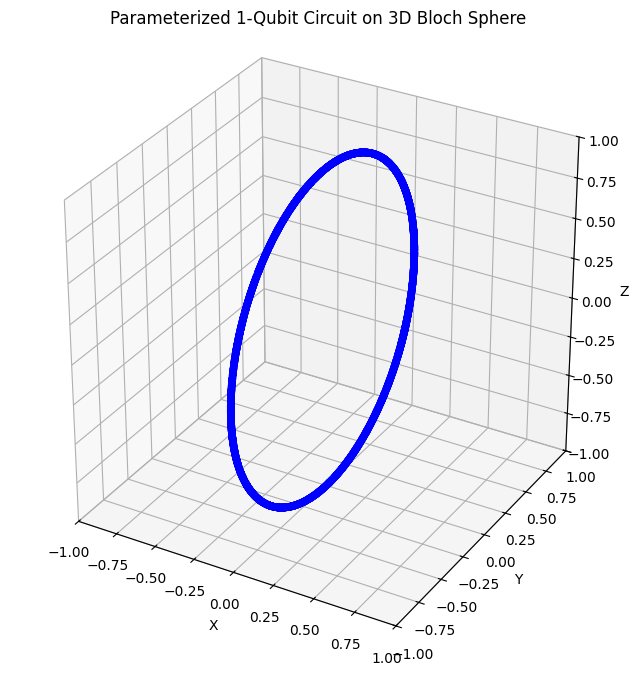

In [6]:
# List to store Bloch Sphere XZ coordinates
bloch_vectors = []

# Generate quantum states and extract Bloch vectors
for i in range(num_samples):
    # Create a circuit and bind parameters
    qc = ansatz1
    bound_qc = qc.assign_parameters({theta: theta_vals[i]}) #, lam: lam_vals[i]})
    state = Statevector.from_instruction(bound_qc)
    rho = DensityMatrix(state)

    X = rho.expectation_value(Pauli("X")).real
    Y = rho.expectation_value(Pauli("Y")).real
    Z = rho.expectation_value(Pauli("Z")).real
    bloch_vectors.append([X,Y,Z])  # Store X, Z components

# Convert to a numpy array for plotting
bloch_vectors = np.array(bloch_vectors)

plot_bloch(bloch_vectors)

We can see our first ansatz returns a ring-shaped distributed quantum states of the Bloch sphere. This makes sense, because we have only given the ansatz a single rotational parameter. So it can only produce states rotated around one axis. Starting from the point $(0,0,1)$ and rotating around one axis will always yield a ring. Then let's check our second ansatz, which has two orthogonal rotational gates - Rx and Rz.

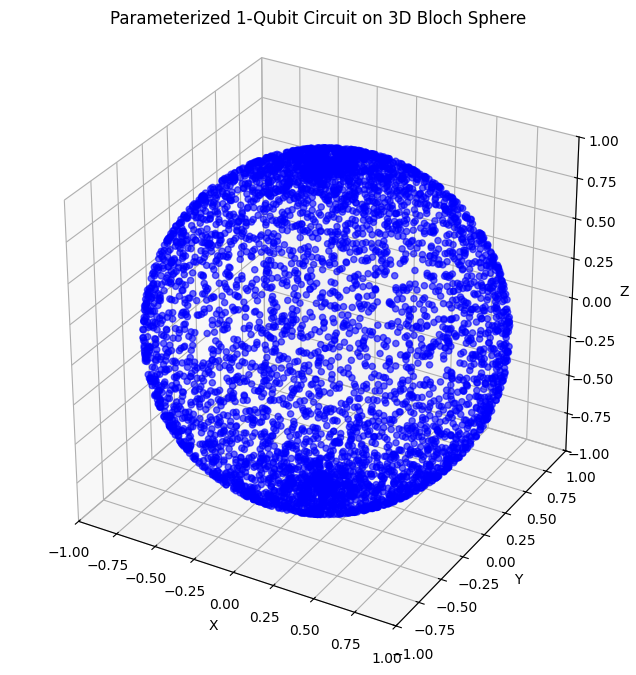

In [7]:
bloch_vectors = []

# Generate quantum states and extract Bloch vectors
for i in range(num_samples):
    # Create circuit and bind parameters
    qc = ansatz2
    bound_qc = qc.assign_parameters({theta: theta_vals[i], phi: phi_vals[i]}) #, lam: lam_vals[i]})
    state = Statevector.from_instruction(bound_qc)
    rho = DensityMatrix(state)

    X = rho.expectation_value(Pauli("X")).real
    Y = rho.expectation_value(Pauli("Y")).real
    Z = rho.expectation_value(Pauli("Z")).real
    bloch_vectors.append([X,Y,Z])  # Store X, Z components

# Convert to numpy array for plotting
bloch_vectors = np.array(bloch_vectors)

plot_bloch(bloch_vectors)

Here, we can see that our second ansatz covers a larger portion of the Bloch sphere. But note that the dots are more concentrated around the poles and more spread out around the equator. Now it is time to check our last ansatz.

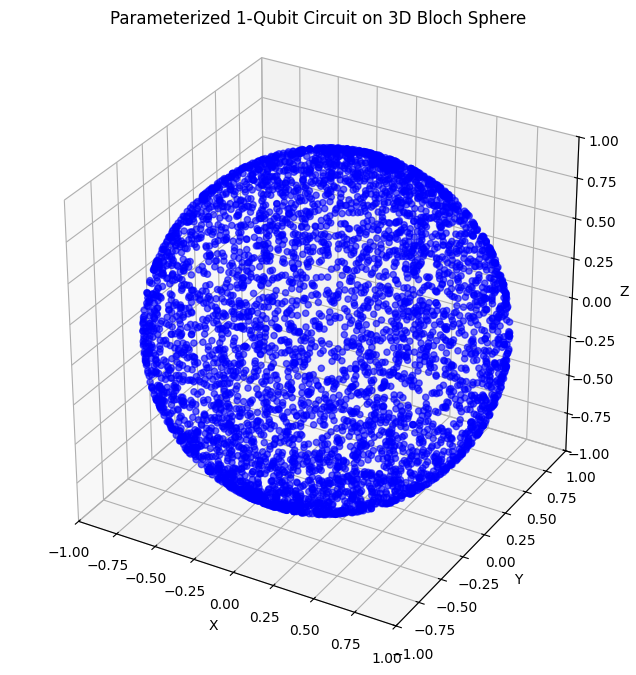

In [8]:
bloch_vectors = []

# Generate quantum states and extract Bloch vectors
for i in range(num_samples):
    # Create circuit and bind parameters
    qc = ansatz3
    bound_qc = qc.assign_parameters({theta: theta_vals[i], phi: phi_vals[i], lam: lam_vals[i]})
    state = Statevector.from_instruction(bound_qc)
    rho = DensityMatrix(state)

    X = rho.expectation_value(Pauli("X")).real
    Y = rho.expectation_value(Pauli("Y")).real
    Z = rho.expectation_value(Pauli("Z")).real
    bloch_vectors.append([X,Y,Z])  # Store X, Z components

# Convert to numpy array for plotting
bloch_vectors = np.array(bloch_vectors)

plot_bloch(bloch_vectors)

Here you can see more evenly distributed quantum states generated by our last ansatz. 

As mentioned, the best thing to do is to gain knowledge about the ground state you're seeking and use an ansatz that is well-suited to probe states close to that ground state. For example, if we knew that our ground state was near a pole, we might select ansatz 2. For simplicity, we will stick with ansatz 3, which uniformly probes the entire Bloch sphere.

As we selected our anstaz, let's draw the circuit.

This circuit has  3 parameters


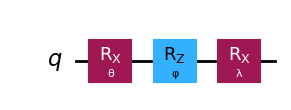

In [9]:
# Pre-defined ansatz circuit and operator class for Hamiltonian

ansatz=ansatz3

num_params = ansatz.num_parameters
print("This circuit has ", num_params, "parameters")

ansatz.draw("mpl", style="iqp")

### Step 2: Optimize for target hardware

When running a calculation on a real quantum computer. We don't just care about the logic of the quantum circuit. We also care about things like what operations can be performed by that particular quantum computer, and where on the quantum computer are the qubits we are using? Are they right next to each other? Are they far apart? So the next step is to rewrite our circuit using gates that are natural for the quantum computer we'll use, and taking qubit layout into account. This can be done by `Transpilation` and after this process, you can see our simple ansatz converted into a different set of gates and our abstract qubits are mapped into physical qubits on a real quantum computer.

Backend: ibm_yonsei
Native gates:  ['ecr', 'id', 'delay', 'measure', 'reset', 'rz', 'sx', 'x'] ,


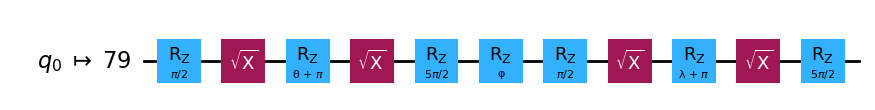

In [12]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

config = backend.configuration()
# config = backend_sim.configuration()


print(f"Backend: {config.backend_name}")
print(f"Native gates: ", config.supported_instructions, ",")


target = backend.target

pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

You can see `Rx, Rz` gates of our ansatz converted into a series of `rz, sx` gates, which are the native gates of our backend. Also, you can see our `q0` is now mapped into the 5th physical qubit. We also need to map our Hamiltonian according to these changes, and the code below is for that.

In [13]:
Hamiltonian_isa = Hamiltonian.apply_layout(layout=ansatz_isa.layout)

### Step 3: Execute on target hardware

Now it is time to run our VQE on a real QPU. For this, first we need a cost function for the optimization process, which evaluates the expectation value of the Hamiltonian with a quantum state, generated by the ansatz. Don't worry! You don't need to code everything by yourself. We prepared a function for this, and what you need to do is only run the cell below.

In [14]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

Finally, we prepare initial parameters for our ansatz and its optimization process. You can simply use all zeros or random values. We have selected initial parameters below, but feel free to comment/uncomment lines in the cell to sample parameters randomly, uniformly from 0 to $2\pi$.

In [15]:
#x0 = np.random.uniform(0, 2*pi, 3)
x0 = [1,1,0]

In [ ]:
# #QPU Est. 2min

# from scipy.optimize import minimize
# # This required 13 min, 20 s QPU time on ibm_cusco, 28 min total time.
# with Batch(backend=backend) as batch:
#     cost_history_dict = {
#         "prev_vector": None,
#         "iters": 0,
#         "cost_history": [],
#     }
#     estimator = Estimator(mode=batch)
#     estimator.options.default_shots = 10000

#     res = minimize(
#         cost_func,
#         x0,
#         args=(ansatz_isa, Hamiltonian_isa, estimator),
#         method="cobyla",
#         options={'maxiter': 10, 'tol':0.01}
#     )
# batch.close()

In [16]:
#QPU Est. 2min

from scipy.optimize import minimize
# This required 13 min, 20 s QPU time on ibm_cusco, 28 min total time.
with Batch(backend=backend_sim) as batch:
    cost_history_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }
    estimator = Estimator(mode=batch)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz, Hamiltonian, estimator),
        method="cobyla",
        options={'maxiter': 10, 'tol':0.01}
    )
batch.close()

Iters. done: 1 [Current cost: -0.33728309999999995]
Iters. done: 2 [Current cost: -0.46897469999999997]
Iters. done: 3 [Current cost: -0.38956409999999997]
Iters. done: 4 [Current cost: -0.38551349999999995]
Iters. done: 5 [Current cost: -0.463464]
Iters. done: 6 [Current cost: -0.4683153]
Iters. done: 7 [Current cost: -0.44754419999999995]
Iters. done: 8 [Current cost: -0.4700109]
Iters. done: 9 [Current cost: -0.46195679999999995]
Iters. done: 10 [Current cost: -0.46530089999999996]


In [17]:
h_vqe = res.fun
print("The reference ground state energy is ", min(eigenvalues))
print("The computed ground state energy is ", h_vqe)

The reference ground state energy is  (-0.471+0j)
The computed ground state energy is  -0.4700109


Congratulations! You have just finished your first quantum chemistry experiment successfully. We can see some difference between the exact ground state energy of the Hamiltonian and ours. But because we used a default error mitigation technique, which corrects readout errors, the difference is minor. This is a very good start!

Note: You can get a better result by setting a level of error mitigation using [resilience_level](https://docs.quantum.ibm.com/guides/configure-error-mitigation). The default value is 1, and if you set a higher value, it will use more QPU time but will return a better result.

### Step 4: Post-process

It is time to take a look at how our classical optimizer worked. Run the cell below and see the convergence pattern.

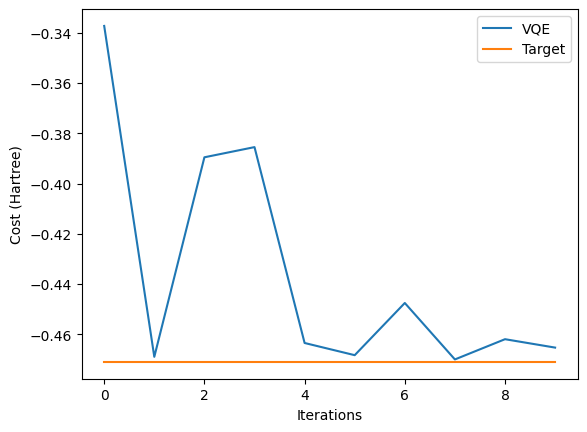

In [18]:
# Plotting functions
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x = np.linspace(0, 10, 10)

# Define the constant function
y_constant = np.full_like(x, h)
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"],label='VQE')
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost (Hartree)")
ax.plot(y_constant, label='Target')
plt.legend()
plt.draw()

We started with a fairly good initial value, such that we obtained a good final value in just 10 steps. You can see big and small peaks, and this is the typical feature of the Cobyla optimizer - it searches the space as if it cannot see the landscape and adjusts step sizes with each measurement.

#### Check your understanding
<details>
<summary>

What is your observation? Which part of the above process is open to improvement in order to obtain results closer to the theoretical values, or closer to the precise ground state energy of the Hamiltonian? What are some things to consider for this?

</summary>

__Answer:__


The first thing to consider is the change in the set of bases used in calculating the Hamiltonian of molecules. As mentioned earlier, the ground state energy of the H atom is -0.5 Hartree, as is well known, and the sto-6g basis we have chosen is not enough to accurately derive this value.

Choosing a more complex kind of basis increases the number of qubits used by the Hamiltonian; therefore, we need to select a more complex and suitable ansatz for chemical problems.

The next to be optimized is the management of noise in the QPU. More advanced error mitigation techniques yield better results but may take longer to use. Also, consider how the shot_number affects the results.

Finally, better convergence performance can also be achieved by trying different optimizers.

</details>


## 4. Compute the ground state energy of the hydrogen molecule with VQE

Now that we have looked at the overall process of VQE using H atoms, we will now calculate the ground state energy of the H2 molecule more quickly.

### Step 1: Map the problem to quantum circuits and operators

Here we also provide you with a one-qubit Hamiltonian that uses the sto6g basis and the Jordan-Wigner transformation, with qubit reduction by using a symmetry of the Hamiltonian. Note that we used an atomic distance between two hydrogen atoms of `0.735` $\mathring A$. 

Unlike the calculation of a single hydrogen atom ($H$), in order to calculate the ground state of a hydrogen molecule($H_2$), in addition to the energy associated with the electronic orbitals, the repulsive force acting between the nuclei of the two hydrogen atoms must be considered. In this step, we will give this value as a constant, and we will actually calculate this value in the check-in problem.
$$\hat{H} = -1.04886 I + -0.79674 Z + 0.18122 X$$

In [19]:
h2_hamiltonian = SparsePauliOp.from_list(
    [("I", -1.04886087), ("Z", -0.7967368), ("X",0.18121804)]
)

#exact ground state energy of hamiltonian
nuclear_repulsion = 0.71997
A = np.array(h2_hamiltonian)
eigenvalues, eigenvectors = np.linalg.eig(A)
print("Electronic ground state energy (Hartree): ", min(eigenvalues).real)
print("Nuclear repulsion energy (Hartree): ", nuclear_repulsion)
print("Total ground state energy (Hartree): ", min(eigenvalues).real + nuclear_repulsion)
h2 = min(eigenvalues).real + nuclear_repulsion

Electronic ground state energy (Hartree):  -1.8659468547627318
Nuclear repulsion energy (Hartree):  0.71997
Total ground state energy (Hartree):  -1.1459768547627318


### Step 2: Optimize for target hardware

Since the number of qubits used by the previous VQE and Hamiltonian is the same as the backend to be used for execution, we will use the existing ansatz and its optimized form.

In [20]:
# h2_hamiltonian_isa = h2_hamiltonian.apply_layout(layout=ansatz_isa.layout)
h2_hamiltonian_isa = h2_hamiltonian.apply_layout(layout=ansatz.layout)

### Step 3: Execute on target hardware

Now it's time to do the calculations on the actual QPU. Almost everything is the same, but we will use the appropriate initial point to fit the Hamiltonian. Also, at an iterative part, some of the settings of the `Estimator`, which is used to calculate the Hamiltonian's expectations for the ansatz in the QPU, will be set slightly differently from the previous calculations. We will discuss this change further in a check-in question.

In [21]:
x0 = [2, 0, 0 ]

In [ ]:
# #QPU Est: 4m

# with Batch(backend=backend) as batch:
#     cost_history_dict = {
#         "prev_vector": None,
#         "iters": 0,
#         "cost_history": [],
#     }
#     estimator = Estimator(mode=batch)
#     estimator.options.default_shots = 10000

#     res = minimize(
#         cost_func,
#         x0,
#         args=(ansatz_isa, h2_hamiltonian_isa, estimator),
#         method="cobyla",
#         options={'maxiter': 15}
#     )
# batch.close()

ValueError: The number of qubits of the circuit (127) does not match the number of qubits of the (0,)-th observable (1).

In [24]:
#QPU Est: 4m

with Batch(backend=backend_sim) as batch:
    cost_history_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }
    estimator = Estimator(mode=batch)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz, h2_hamiltonian, estimator),
        method="cobyla",
        options={'maxiter': 15}
    )
batch.close()

Iters. done: 1 [Current cost: -0.711515633704]
Iters. done: 2 [Current cost: -0.2598158620639999]
Iters. done: 3 [Current cost: -0.2583811132479999]
Iters. done: 4 [Current cost: -0.5716465429839999]
Iters. done: 5 [Current cost: -1.723846191544]
Iters. done: 6 [Current cost: -1.671556465376]
Iters. done: 7 [Current cost: -1.8088489539119998]
Iters. done: 8 [Current cost: -1.8040015685599997]
Iters. done: 9 [Current cost: -1.8065169114800002]
Iters. done: 10 [Current cost: -1.822403494408]
Iters. done: 11 [Current cost: -1.7105510668479997]
Iters. done: 12 [Current cost: -1.826405286792]
Iters. done: 13 [Current cost: -1.811771504704]
Iters. done: 14 [Current cost: -1.854926569664]
Iters. done: 15 [Current cost: -1.8637044248159997]


In [25]:
h2_vqe = res.fun+ nuclear_repulsion
print("The reference ground state energy is ", min(eigenvalues).real+ nuclear_repulsion)
print("The computed ground state energy is ", h2_vqe)

The reference ground state energy is  -1.1459768547627318
The computed ground state energy is  -1.1437344248159997


Despite VQE theoretically providing an upper bound to the true ground state energy, practical implementations on real or noisy simulated quantum hardware, as well as approximations made in preparing the Hamiltonian (like basis sets or qubit reduction), can introduce errors that sometimes result in a measured energy slightly lower than the exact theoretical value or a specific numerical reference. Although there are some errors, the results seem to be satisfactory, especially given the small number of steps. Now, let's wrap up this VQE calculation by looking at how the optimizer worked.

### Step 4: Post-process

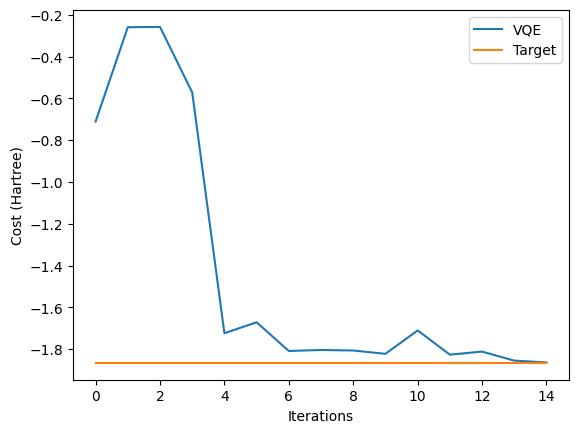

In [26]:
fig, ax = plt.subplots()
x = np.linspace(0, 10, 15)

# Define the constant function
y_constant = np.full_like(x, min(eigenvalues))
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"],label='VQE')
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost (Hartree)")
ax.plot(y_constant, label='Target')
plt.legend()
plt.draw()

#### Check your understanding
Let's compute the nuclear repulsion energy of $H_2$ molecule which we included as a constant value (0.71997 Hartree).
<img src="h2.png" width=300>

<details>
<summary>

Please use [Coulomb's law](https://en.wikipedia.org/wiki/Coulomb%27s_law) and use [atomic unit](https://en.wikipedia.org/wiki/Atomic_units) to make sure you get the value in `Hartree`.

</summary>

__Answer:__


Since both hydrogen nuclei are positively charged, they repel each other due to electrostatic force. This repulsion is described by Coulomb's law:

$$E_{repulsive} = \frac{e^2}{4\pi\epsilon_0R}$$

where $e$ is a charge of proton, $\epsilon_0$ is a vacuum permittivity, $R$ is the distance between the two nuclei, measured in meters or Bohr radii in unit of joules(J).

To compute this energy in Hartrees, we need to convert above equation into Atomic Unit (AU) system. In the atomic unit system, $e^2 = 1$, $4\pi\epsilon_0=1$ and Bohr radius ($a_0$) is 1 and becomes the fundamental length scale in AU. With these simplifications, Coulomb's law reduced to:

$$E_{repulsion} = \frac{1}{R}$$

where $R$ must be measured in Bohr radii ($a_0$)

To convert given nuclear separation in $\r{A}$ into $a_0$, we need this conversion relation:

$$1\r{A} = 1.88973 a_0$$

so $0.735\r{A}$ becomes $0.735 * 1.88973 = 1.38895 a_0$.

Therefore, the nuclear repulsion energy of a given $H2$ is

$$E_{repulsion} = \frac{1}{R} = \frac{1}{1.38895} = 0.71997 Hartree$$

</details>


## 5. Compute reaction energy of $H + H = H_2$

Now let's use what we've obtained from quantum computation! You've used VQE, a variational quantum algorithm, to calculate the ground state energy of the $H$ atom and of the $H_2$ molecule. What's left is to use the calculated values to calculate the reaction energy of the $H+H=H_2$ process.

Reaction energy is the energy change that happens when substances react to form new substances. Imagine you’re building something: sometimes you need to put energy into it (like stacking blocks), and sometimes energy is released (like a ball rolling downhill). In chemistry, reactions either absorb energy (endothermic) or release energy (exothermic). 

The reaction energy of $H+H = H_2$ process can be compute by below formula:

$E_{reaction} = E_{H_2} - (E_H + E_H)$

By running the cell below, let's see this visually. Here we will use the exact ground state value of each Hamiltonian and will compare the reaction energy of exact solution and VQE results.

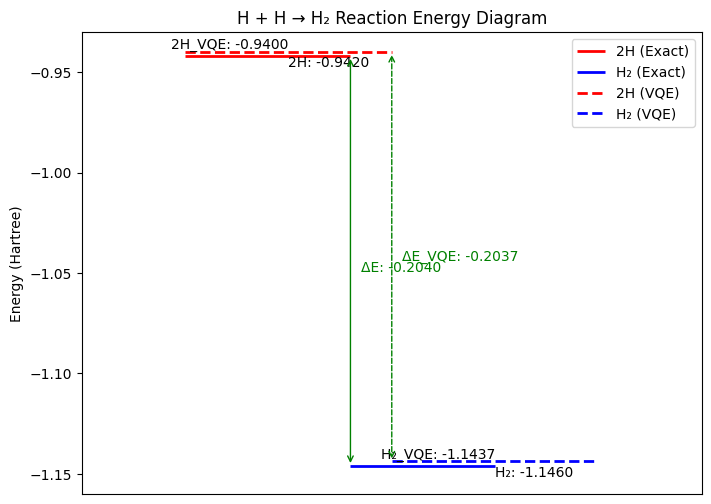

In [27]:
# Theoretical values
E_H_theo = h.real
E_H2_theo = h2

# Experimental values
E_H_exp = h_vqe
E_H2_exp = h2_vqe

# Calculate reaction energies
E_reaction_theo = E_H2_theo - (2 * E_H_theo)
E_reaction_exp = E_H2_exp - (2 * E_H_exp)

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, 3)
ax.set_ylim(-1.16, -0.93)  # Adjust y-axis range to highlight differences
ax.set_xticks([])
ax.set_ylabel('Energy (Hartree)')
ax.set_title('H + H → H₂ Reaction Energy Diagram')

# Plot theoretical energy levels
ax.hlines(y=2*E_H_theo, xmin=0.5, xmax=1.3, linewidth=2, color='r', label='2H (Exact)')
ax.hlines(y=E_H2_theo, xmin=1.3, xmax=2, linewidth=2, color='b', label='H₂ (Exact)')

# Plot experimental energy levels
ax.hlines(y=2*E_H_exp, xmin=0.5, xmax=1.5, linewidth=2, color='r', linestyle='dashed', label='2H (VQE)')
ax.hlines(y=E_H2_exp, xmin=1.5, xmax=2.5, linewidth=2, color='b', linestyle='dashed', label='H₂ (VQE)')

# Add labels
ax.text(1, 2*E_H_theo, f'2H: {2*E_H_theo:.4f}', verticalalignment='top', horizontalalignment='left')
ax.text(2, E_H2_theo, f'H₂: {E_H2_theo:.4f}', verticalalignment='top', horizontalalignment='left')
ax.text(1, 2*E_H_exp, f'2H_VQE: {2*E_H_exp:.4f}', verticalalignment='bottom', horizontalalignment='right')
ax.text(2, E_H2_exp, f'H₂_VQE: {E_H2_exp:.4f}', verticalalignment='bottom', horizontalalignment='right')

# Add arrows for reaction energy with ΔE label in the middle
mid_y_theo = (2*E_H_theo + E_H2_theo) / 2
mid_y_exp = (2*E_H_exp + E_H2_exp) / 2
ax.annotate('', xy=(1.3, E_H2_theo), xytext=(1.3, 2*E_H_theo),
            arrowprops=dict(arrowstyle='<->', color='g'))
ax.text(1.35, mid_y_theo, f'ΔE: {E_reaction_theo:.4f}', color='g', verticalalignment='top')

ax.annotate('', xy=(1.5, E_H2_exp), xytext=(1.5, 2*E_H_exp),
            arrowprops=dict(arrowstyle='<->', color='g', linestyle='dashed'))
ax.text(1.55, mid_y_exp, f'ΔE_VQE: {E_reaction_exp:.4f}', color='g', verticalalignment='center')

# Add legend
ax.legend()

plt.show()


As shown in the figure, although there are some errors, the exact ground state energy of Hamiltonians and the reaction energy calculated using the VQE results are similar, approximately -0.2 Hartree.

It should be noted here that the reaction energy of this process has a negative value, which means that the energy is released through the process, and the resulting molecule has a lower energy than two single atoms.


## 6. Conclusion

Let's summarize what we've learned so far.

We first looked at two important approximation techniques needed to solve quantum chemistry problems: the variational principle and basis set choices, which are both fundamental to VQE. We explored the variational principle by hand, calculating the ground state energy of the simple harmonic oscillator.

Next, we dove into VQE, a widely used algorithm for calculating the ground state energy of a quantum system. We ran code to calculate the ground state energies for atomic Hydrogen ($H$) and the Hydrogen molecule ($H_2$). In particular, we learned that it is necessary to obtain the appropriate molecular Hamiltonian for the system and to transform it into a form executable on a quantum computer. We also saw that the ansatz, a parameterized quantum circuit, is needed to prepare trial quantum states within VQE, and we discussed the importance of choosing an appropriate ansatz circuit structure. We also learned that VQE relies on an iterative optimization process using a classical computer, guiding the quantum circuit to find the lowest energy state, and saw how the convergence of this process is monitored.

Finally, we used the computed ground state energies of $H$ and $H_2$ obtained via VQE to calculate the reaction energy for the process $H + H \rightarrow H_2$.

VQE is a powerful near-term quantum algorithm, but it's important to be aware of its limitations. The performance of VQE heavily depends on the choice of the ansatz – finding an efficiently preparable ansatz that can accurately represent the true ground state becomes increasingly challenging for larger, more complex molecules. Furthermore, current quantum hardware is susceptible to noise, which can impact the accuracy of VQE results, particularly for deeper circuits or larger numbers of qubits. Despite these challenges, VQE serves as a foundational algorithm, and ongoing research is exploring more sophisticated variational methods and error mitigation techniques to push the boundaries of what is possible in quantum chemistry on near-term quantum computers. For instance, algorithms like Sample-based Quantum Diagonalization (SQD) are being developed, which leverage samples obtained from quantum circuits combined with classical diagonalization in a subspace to improve energy estimation and address some of the limitations faced by VQE, particularly regarding measurement efficiency and noise robustness.

## 7. Review and questions

### Critical concepts:

- Variational Quantum Algorithm is a computing paradigm in which a classical computer and a quantum computer work together to solve a problem.
- In VQE, we start with a Hamiltonian of our system and map it onto qubits for execution on the quantum computer. We select a parameterized quantum circuit, an ansatz, and make repeated measurements, varying the parameters of the ansatz, until the lowest energy value is reached. The search through parameter space is done using a classical optimizer. To achieve good results, it is necessary to select a good ansatz and an appropriate optimizer.
- Reaction energy is the total energy change in a chemical reaction, determined by the difference between the energy of the reactants and the products.


### True/false
1. The variational principle states that the expectation value of the energy for any trial wavefunction is always greater than or equal to the true ground state energy. __True__
2. A basis set is a collection of functions used to approximate quantum wavefunctions. __True__
3. VQE is a quantum algorithm used to exactly solve the Schrödinger equation for a given Hamiltonian. __False__
4. In VQE, a parameterized quantum circuit (an ansatz) is used to prepare trial wavefunctions. __True__
5. The choice of optimizer in VQE (e.g., COBYLA, SPSA, or ADAM) does not impact the quality of the result. __False__
6. Qiskit's `Estimator` is used to directly compute expectation values of Hamiltonians in VQE. __True__


### Multiple Choice Questions:

1. What is the purpose of the Hamiltonian in VQE?

- A) To generate random quantum states
- __B)__ To determine the energy of quantum states
- C) To optimize quantum circuits
- D) To create entanglement

2. What is the primary objective of the VQE algorithm?

- __A)__ To find the ground state energy of a Hamiltonian
- B) To create entanglement between qubits
- C) To perform Grover's search
- D) To break the RSA encryption

3. How many quantum states are generated in this notebook to compare the ansatzs?
- A) 100
- B) 1000 
- __C)__ 5000
- D) 10,000

4. Why is a classical optimizer required in VQE?
- A) To perform quantum measurements
- __B)__ Update ansatz parameters to minimize energy
- C) To entangle qubits
- D) To generate quantum randomness

5. Why is the ansatz designed to be parameterized?
- A) To allow quantum state preparation
- __B)__ To allow a wide space of quantum states to be searched 
- C) To reduce circuit complexity
- D) To measure eigenvalues directly

6. Which of the following is the most correct statement about choosing a good ansatz?
- A) An ansatz must produce states evenly distributed over the Bloch sphere, or it will fail.
- __B)__ An ansatz should be tailored to your system to make sure it can generate states close to the ground state.
- C) An ansatz should produce random states using its variational parameters.
- D) A better ansatz always has more variational parameters.




## (Optional) Appendix: Optimizer overhead by ansatz complexity

VQE faces several well-known challenges[ref 6], and the following are related to what we have learned above.

1. Ansatz Selection Challenges
There is an inherent challenge in selecting the right variational ansatz. Chemistry-inspired ansätze (like UCCSD) provide physical accuracy but require deep circuits, while hardware-efficient ansätze have shallower circuits but may lack physical interpretability. Also, many ansätze introduce excessive variational parameters that contribute little to improving accuracy but significantly increase optimization difficulty.

2. Optimization Difficulties
The optimization landscape of VQE can have regions where gradients vanish exponentially (barren plateaus), making it difficult for classical optimizers to update the variational parameters efficiently. For this, researchers have tried to use different types of optimizers - gradient-based and gradient-free, but both face challenges. Gradient-based optimizers suffer from barren plateaus, while gradient-free methods require a large number of function evaluations.

One more well-known challenge is optimizer overhead, which is related to the scale of the problem. The quantum circuits required for VQE grow in depth and complexity as the problem size increases; this typically also increases the number of parameters to optimize. The optimization process becomes intractable as the number of parameters increases, leading to slow convergence and difficulties in finding the optimal solution.

Here we will take a look at these challenges by using VQE for $H_2$ molecule, with a two different type of ansatz.

(Note: This can take more QPU time, so feel free to use a noisy simulator for this if you don't have enough time.)

In [28]:
from qiskit.circuit import ParameterVector
num_iter = 4
alpha = ParameterVector("alpha", 3)
beta = ParameterVector("beta", 3*num_iter)

#step1: Map problem to quantum circuits and operators
hamiltonian = SparsePauliOp.from_list(
    [("I", -1.04886087), ("Z", -0.7967368), ("X",0.18121804)]
)

ansatz_1 = ansatz3
ansatz_2 = QuantumCircuit(1)
for i in range(num_iter):
    ansatz_2.rx(beta[i*3 + 0],0)
    ansatz_2.rz(beta[i*3 + 1],0)
    ansatz_2.rx(beta[i*3 + 2],0)

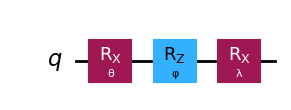

In [29]:
ansatz_1.draw('mpl')

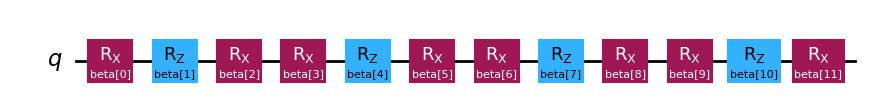

In [30]:
ansatz_2.draw('mpl')

In [31]:
#Step 2: Optimize for target hardware

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa_1 = pm.run(ansatz_1)
ansatz_isa_2 = pm.run(ansatz_2)
hamiltonian_isa_1 = hamiltonian.apply_layout(layout=ansatz_isa_1.layout)
hamiltonian_isa_2 = hamiltonian.apply_layout(layout=ansatz_isa_2.layout)

Now let's run a VQE with an initial point made of all ones, with maximum 50 steps and compare the convergence of both runs.

In [ ]:
# #Step 3: Execute on target hardware

# from scipy.optimize import minimize

# x0 = np.ones(ansatz_1.num_parameters)
# with Batch(backend=backend) as batch:
#     cost_history_dict = {
#         "prev_vector": None,
#         "iters": 0,
#         "cost_history": [],
#     }
#     estimator = Estimator(mode=batch)
#     estimator.options.default_shots = 10000

#     res = minimize(
#         cost_func,
#         x0,
#         args=(ansatz_isa_1, hamiltonian_isa_1, estimator),
#         method="cobyla",
#         options={'maxiter': 30}
#     )
# batch.close()

Iters. done: 1 [Current cost: -0.850228820208]
Iters. done: 2 [Current cost: -0.42408650275199994]
Iters. done: 3 [Current cost: -0.41994907457599995]
Iters. done: 4 [Current cost: -1.3682458663039998]
Iters. done: 5 [Current cost: -1.768108728736]
Iters. done: 6 [Current cost: -1.4651230553999999]
Iters. done: 7 [Current cost: -1.285345480016]
Iters. done: 8 [Current cost: -1.806756324328]
Iters. done: 9 [Current cost: -1.7857874891119998]
Iters. done: 10 [Current cost: -1.7947303216479997]
Iters. done: 11 [Current cost: -1.791162695784]
Iters. done: 12 [Current cost: -1.796205672104]
Iters. done: 13 [Current cost: -1.80736997536]
Iters. done: 14 [Current cost: -1.8137401074639998]
Iters. done: 15 [Current cost: -1.8141287722560002]
Iters. done: 16 [Current cost: -1.8127815061600001]
Iters. done: 17 [Current cost: -1.8250168501600001]
Iters. done: 18 [Current cost: -1.813146405704]
Iters. done: 19 [Current cost: -1.827580158272]
Iters. done: 20 [Current cost: -1.8299347476399999]
Iter

In [38]:
#Step 3: Execute on target hardware

from scipy.optimize import minimize

x0 = np.ones(ansatz_1.num_parameters)
with Batch(backend=backend_sim) as batch:
    cost_history_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }
    estimator = Estimator(mode=batch)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_1, hamiltonian, estimator),
        method="cobyla",
        options={'maxiter': 30}
    )
batch.close()

Iters. done: 1 [Current cost: -0.853472636544]
Iters. done: 2 [Current cost: -0.405011078056]
Iters. done: 3 [Current cost: -0.4061577188959999]
Iters. done: 4 [Current cost: -1.375661459856]
Iters. done: 5 [Current cost: -1.7885714254319998]
Iters. done: 6 [Current cost: -1.508636037368]
Iters. done: 7 [Current cost: -1.3073097827199998]
Iters. done: 8 [Current cost: -1.8112012140159999]
Iters. done: 9 [Current cost: -1.829336741528]
Iters. done: 10 [Current cost: -1.814577419064]
Iters. done: 11 [Current cost: -1.84683490644]
Iters. done: 12 [Current cost: -1.8194178218800001]
Iters. done: 13 [Current cost: -1.848302190248]
Iters. done: 14 [Current cost: -1.851627209864]
Iters. done: 15 [Current cost: -1.84596944472]
Iters. done: 16 [Current cost: -1.838569496088]
Iters. done: 17 [Current cost: -1.86245092088]
Iters. done: 18 [Current cost: -1.860156909264]
Iters. done: 19 [Current cost: -1.8636044637359999]
Iters. done: 20 [Current cost: -1.8671906863599999]
Iters. done: 21 [Current

In [39]:
#Save Cost_history as a new list
ansatz_1_history =  cost_history_dict["cost_history"]

In [ ]:
# x0 = np.ones(ansatz_2.num_parameters)
# with Batch(backend=backend) as batch:
#     cost_history_dict = {
#         "prev_vector": None,
#         "iters": 0,
#         "cost_history": [],
#     }
#     estimator = Estimator(mode=batch)
#     estimator.options.default_shots = 10000

#     res = minimize(
#         cost_func,
#         x0,
#         args=(ansatz_isa_2, hamiltonian_isa_2, estimator),
#         method="cobyla",
#         options={'maxiter': 30}
#     )
# batch.close()

Iters. done: 1 [Current cost: -0.773770860104]
Iters. done: 2 [Current cost: -0.4355157713119999]
Iters. done: 3 [Current cost: -1.32877522468]
Iters. done: 4 [Current cost: -0.906956534048]
Iters. done: 5 [Current cost: -0.90345213728]
Iters. done: 6 [Current cost: -0.7421270506]
Iters. done: 7 [Current cost: -1.542036886408]
Iters. done: 8 [Current cost: -1.634120172752]
Iters. done: 9 [Current cost: -1.253717181232]
Iters. done: 10 [Current cost: -1.1493776517039997]
Iters. done: 11 [Current cost: -1.157504367064]
Iters. done: 12 [Current cost: -1.802518774032]
Iters. done: 13 [Current cost: -1.240463146552]
Iters. done: 14 [Current cost: -1.677600405008]
Iters. done: 15 [Current cost: -1.808202333192]
Iters. done: 16 [Current cost: -1.8412513888800002]
Iters. done: 17 [Current cost: -1.845389412792]
Iters. done: 18 [Current cost: -0.9245632471599999]
Iters. done: 19 [Current cost: -1.81372795644]
Iters. done: 20 [Current cost: -1.5842268022239998]
Iters. done: 21 [Current cost: -1.

In [35]:
x0 = np.ones(ansatz_2.num_parameters)
with Batch(backend=backend_sim) as batch:
    cost_history_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }
    estimator = Estimator(mode=batch)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_2, hamiltonian, estimator),
        method="cobyla",
        options={'maxiter': 30}
    )
batch.close()

Iters. done: 1 [Current cost: -0.7552478324319999]
Iters. done: 2 [Current cost: -0.42706099575199996]
Iters. done: 3 [Current cost: -1.335329714544]
Iters. done: 4 [Current cost: -0.8967776833839998]
Iters. done: 5 [Current cost: -0.9126693006]
Iters. done: 6 [Current cost: -0.7567857625679999]
Iters. done: 7 [Current cost: -1.5657146535839999]
Iters. done: 8 [Current cost: -1.652856926616]
Iters. done: 9 [Current cost: -1.285399805168]
Iters. done: 10 [Current cost: -1.1517509988719998]
Iters. done: 11 [Current cost: -1.154111218264]
Iters. done: 12 [Current cost: -1.8171787311519998]
Iters. done: 13 [Current cost: -1.24556101692]
Iters. done: 14 [Current cost: -1.6830513191360001]
Iters. done: 15 [Current cost: -1.8179287747519999]
Iters. done: 16 [Current cost: -1.8496305643439999]
Iters. done: 17 [Current cost: -1.8427036503440002]
Iters. done: 18 [Current cost: -0.9404905122479998]
Iters. done: 19 [Current cost: -1.8183858692239998]
Iters. done: 20 [Current cost: -1.654686378104]

In [36]:
ansatz_2_history =  cost_history_dict["cost_history"]

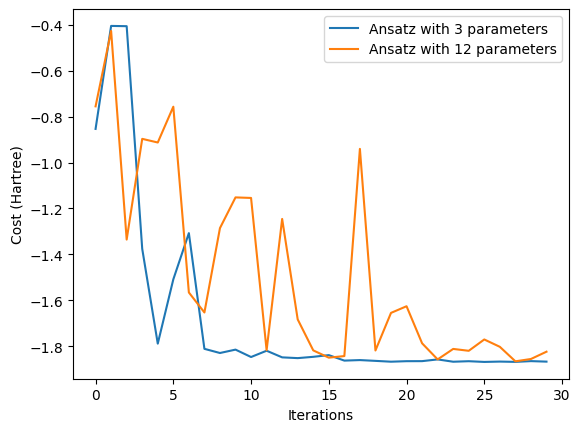

In [40]:
fig, ax = plt.subplots()

# Define the constant function)
ax.plot(range(cost_history_dict["iters"]), ansatz_1_history,label='Ansatz with 3 parameters')
ax.plot(range(cost_history_dict["iters"]), ansatz_2_history,label='Ansatz with 12 parameters')
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost (Hartree)")
plt.legend()
plt.draw()

The graph above clearly demonstrates that the optimization process of the ansatz with more variables takes more time. 

Rather than relying on simple 1-qubit circuits and a straightforward Ansatz, the complexity of optimization increases when larger quantum circuits and more complex structured Ansatz are required. This highlights a well-known challenge in Variational Quantum Eigensolvers (VQE): the overhead of the optimizer.

Researchers continue to develop various advanced methodologies that can use quantum computers for chemistry problems. You can access a variety of educational materials at [IBM Quantum Learning](https://quantum.cloud.ibm.com/learning/en).



## References

- [[ref 1](https://link.springer.com/article/10.1007/BF02650179) ] Richard P. Feynman, Simulating Physics with Computers, International Journal of Theoretical Physics, 1982.
- [ref 2] Marov, M.Y. (2015). The Structure of the Universe. In: The Fundamentals of Modern Astrophysics. Springer, New York, NY.
- [[ref 3](https://www.ibm.com/quantum/blog/photoresists-quantum-chemistry-jsr)] How to solve difficult chemical engineering problems with quantum computing, IBM Research Blog, 2023.
- [[ref 4](https://ieeexplore.ieee.org/document/8585034)] Y. Cao, J. Romero and A. Aspuru-Guzik, "Potential of quantum computing for drug discovery," in IBM Journal of Research and Development, vol. 62, no. 6, pp. 6:1-6:20, 1 Nov.-Dec. 2018
- [[ref 5](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.32.170)] Present State of Molecular Structure Calculation, REv. Mod. Phys. 32, 170, 1960
- [[ref 6](https://jmsh.springeropen.com/articles/10.1186/s41313-021-00032-6)] Fedorov, D.A., Peng, B., Govind, N. et al. VQE method: a short survey and recent developments. Mater Theory 6, 2 (2022)